## <center> **Livrable n°1 : Classification binaire** </center>

‎ 

Réalisé par le **groupe n°2** :
- BERTHO Lucien
- BOSACKI Paul
- GAURE Warren
- GRENOUILLET Théo
- VALLEMONT Hugo


‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Démarche suivie](#demarche)
4. [Importation des bibliothèques](#import)
5. [Adaptation pour GPU](#gpu)
6. [Préparation et chargement des données](#load)
7. [Exploration des données](#exploration)
8. [Configuration de l'environnement](#configuration)
9. [Choix de l'architecture](#architecture)
10. [Réalisation du modèle](#modele)
11. [Entraînement et évaluation du modèle](#train)
12. [Amélioration du modèle](#amelioration)
13. [Première version complète du modèle CNN](#first-version)
14. [Seconde version du modèle CNN](#second-version)
15. [Modèle de classification binaire](#binaire)
16. [Comparatif des modèles](#comparaison)
17. [Calcul des métriques de performance](#metrics)
18. [Conclusion](#conclusion)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

TouNum souhaite automatiser la sélection des photos destinées à l'annotation. Ce livrable propose une méthode de classification basée sur les réseaux de neurones pour filtrer les images qui ne sont pas des photos. La solution reposera sur l'architecture de réseau retenue en fonction des résultats obtenus.

---

### 3. <a id='demarche'>Démarche suivie</a>

Pour ce livrable, nous avons fait le choix de représenter la démarche que nous avons décidé de suivre sous la forme d'un pipeline. Celui-ci représente les diverses grandes étapes que nous avons réalisé pour parvenir au but mentionné dans la partie précédente.

![Pipeline](./results/pipeline.png)

---

### 4. <a id='import'>Importation des bibliothèques</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import collections
import os
import shutil
import datetime
import keras_tuner as kt
import pandas as pd
import visualkeras

from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image, UnidentifiedImageError
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

---

### 5. <a id='gpu'>Adaptation pour GPU</a>

Afin d'entraîner nos modèles sur le GPU de nos ordinateurs, une configuration est nécéssaire. Celle-ci va optimiser la demande de mémoire pour qu'elle soit allouée de manière croissante. Cela va permettre d'éviter d'allouer directement le maximum dès le début et éviter une surutilisation de celle-ci.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            details = tf.config.experimental.get_device_details(gpu)
            print(f"Nom du GPU détecté : {details.get('device_name', 'Nom inconnu')}")
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

---

### 6. <a id='load'>Préparation et chargement des données</a>

Une fois les bibliothèques importées, nous pouvons commencer à préparer le terrain en amont et charger les données pour qu'elles puissent être utilisées dans notre pipeline.

#### 6.1. <a>Filtrage des données</a>

Dans un premier temps, nous devons veiller à ce que nous aillons bien reçu uniquement des images, c'est-à-dire vérifier qu'il n'y ait pas d'intrus comme des fichiers textes ou autres.

In [3]:
dataset_directory = "dataset_livrable_1/"

In [ ]:
def is_image(filename):
    try:
        with Image.open(filename) as img:
            img.verify()
        return True
    except (UnidentifiedImageError, OSError):
        return False

def move_non_images(directory):
    dump_directory = "dump"
    os.makedirs(dump_directory, exist_ok = True)
    
    for folder, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(folder, file)
            if not is_image(file_path):
                print(f"Déplacement de {file_path} dans le dossier dump/")
                dest_path = os.path.join(dump_directory, file)
                try:
                    shutil.move(file_path, dest_path)
                except:
                    print("Erreur lors du déplacement")
                
move_non_images(dataset_directory)

──────────────────────────────────────────────────

#### 6.2. <a>Vérification des images</a>

Tout d'abord, nous devons nous assurer du bon état des images reçues, c'est-à-dire vérifier si elles n'ont pas été corrompues ou mal formatées.

In [ ]:
def is_valid_image(path):
    try:
        img_raw = tf.io.read_file(path)
        _ = tf.image.decode_image(img_raw, channels=3)
        return (path, True)
    except Exception:
        return (path, False)

def clean_corrupted_images(directory, extensions=("jpg", "jpeg", "png"), max_workers=8):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extensions):
                image_paths.append(os.path.join(root, file))

    print(f"Scan de {len(image_paths)} images dans {directory}")

    corrupted_count = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(is_valid_image, path) for path in image_paths]
        for future in as_completed(futures):
            path, is_valid = future.result()
            if not is_valid:
                try:
                    os.remove(path)
                    corrupted_count += 1
                except Exception as e:
                    print(f"Erreur de suppression {path} : {e}")

    print(f"Vérification terminée : {corrupted_count} image(s) corrompue(s) supprimée(s).")
    

clean_corrupted_images(dataset_directory)

──────────────────────────────────────────────────

#### 6.3. <a>Gestion des logs</a>

Nous créons ici un dossier qui va nous permettre de stocker les logs qui seront utilisés par [TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard).

In [4]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

──────────────────────────────────────────────────

#### 6.4. <a>Chargement des images</a>

Les images doivent être séparées en deux ensembles : un pour l'entraînement du modèle, l'autre pour son évaluation.

In [5]:
image_h = 128
image_w = 128
batch_s = 16

train_set, test_set = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = SEED,
    validation_split = 0.2,
    subset = "both"
)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Using 8279 files for validation.


---

### 7. <a id='exploration'>Exploration des données</a>

Maintenant que les données ont pu être préparées et chargées, nous pouvons nous intéresser de plus près à elles, à commencer par le nom des classes.

#### 7.1. <a>Nom des classes</a>

In [6]:
class_names = train_set.class_names
print(f"Classes détectées : {class_names}")

Classes détectées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


Nous retrouvons bien les 5 classes attendues.

──────────────────────────────────────────────────

#### 7.2. <a>Répartition des données</a>

Nous regardons maintenant la répartition des données entre les classes.

In [ ]:
def print_class_distribution(dataset, name):
    label_counts = collections.Counter(label.numpy() for _, label in dataset.unbatch())

    classes = {0: "peintures", 1: "photos", 2: "schémas", 3: "croquis", 4: "textes scannés"}

    total = sum(label_counts.values())
  
    labels = []
    counts = []
    percentages = []

    for label_id in sorted(label_counts):
        class_name = classes.get(label_id, f"Classe inconnue ({label_id})")
        count = label_counts[label_id]
        labels.append(class_name)
        counts.append(count)
        percentages.append(count / total * 100)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts)

    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{pct:.1f}%", ha='center', va='bottom')

    plt.title(f"Répartition des classes ({name}_set - {total} images)")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

In [ ]:
print_class_distribution(train_set, "train")

In [ ]:
print_class_distribution(test_set, "test")

Comme on peut l'observer sur les histogrammes générés, la répartition des données entre les différentes classes est déséquilibrée dans les deux ensembles. Bien que cela ne soit pas gênant dans le set de test car nous souhaitons avoir des conditions proches de la réalité, cela peut poser problème lors de l'entraînement de notre modèle, qui risque d'être biaisé envers les classes majoritaires.

──────────────────────────────────────────────────

#### 7.3. <a>Taille des données</a>

Nous affichons maintenant la taille des données, information pouvant être utile par la suite.

In [7]:
images, labels = next(iter(train_set.take(1)))
print(f"Tensor des images : {images.shape}")
print(f"Tensor des labels : {labels.shape}")

Tensor des images : (16, 128, 128, 3)
Tensor des labels : (16,)


──────────────────────────────────────────────────

#### 7.4. <a>Affichage des images</a>

Nous affichons quelques images pour voir plus en détail ce à quoi nous avons affaire.

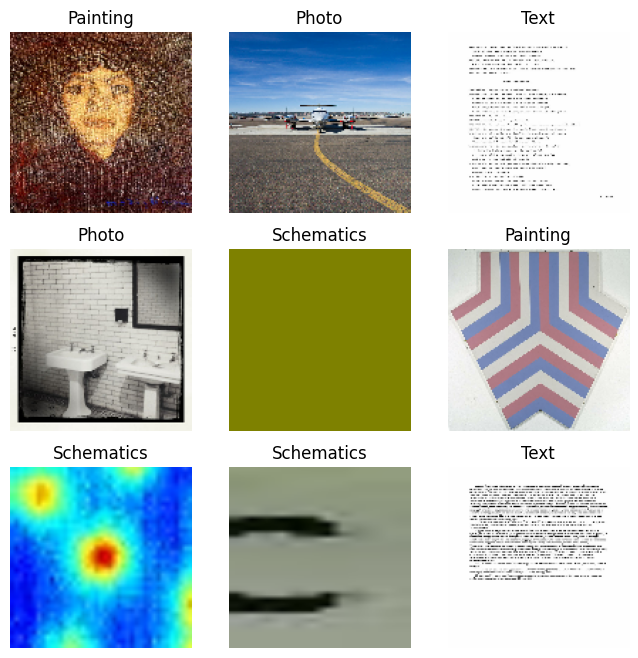

In [8]:
plt.figure(figsize = (8, 8))
for images, labels in train_set.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

──────────────────────────────────────────────────

#### 7.5. <a>Résolution originelle des images</a>

Nous affichons la résolution originelle de quelques images.

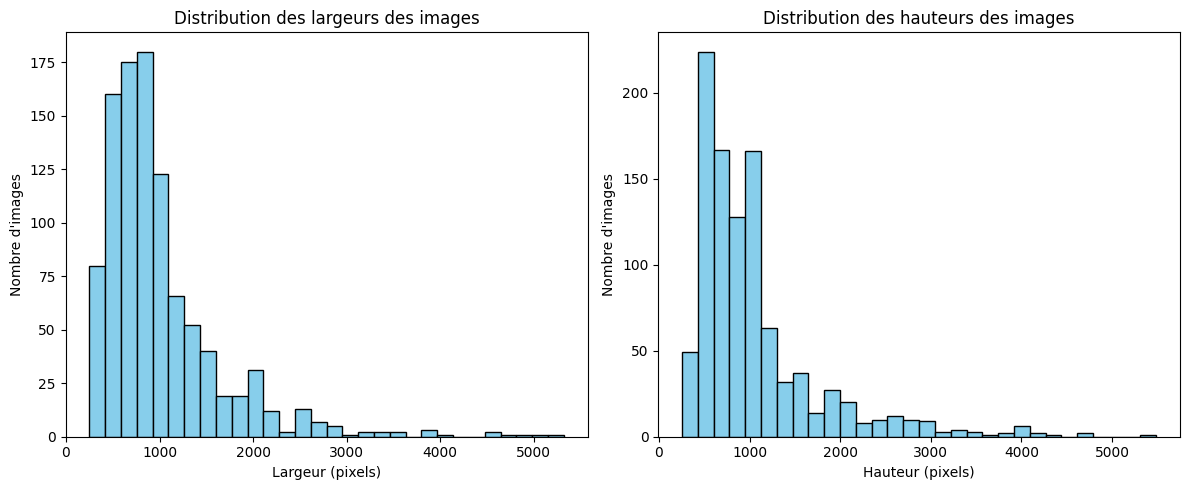

In [9]:
image_paths = []
for root, dirs, files in os.walk(dataset_directory):
    for file in files:
        if len(image_paths) <= 1000:
            image_paths.append(os.path.join(root, file))

widths, heights = [], []
for path in image_paths:
    try:
        with Image.open(path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    except:
        continue

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins = 30, color='skyblue', edgecolor='black')
plt.title("Distribution des largeurs des images")
plt.xlabel("Largeur (pixels)")
plt.ylabel("Nombre d'images")

plt.subplot(1, 2, 2)
plt.hist(heights, bins = 30, color='skyblue', edgecolor='black')
plt.title("Distribution des hauteurs des images")
plt.xlabel("Hauteur (pixels)")
plt.ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

---

### 8. <a id='configuration'>Configuration de l'environnement</a>

Pour optimiser les performances des calculs, nous allons configurer les données à l’aide de deux fonctions : `Dataset.cache` et `Dataset.prefetch`.  
- [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stocke les données en mémoire pour éviter les accès répétés au disque.  
- [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) permet de traiter un élément en arrière-plan pendant l'entraînement ou l'évaluation.  

En combinant ces techniques, nous réduirons significativement le temps de traitement et la charge computationnelle.

In [10]:
if not gpus:
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)

---

### 9. <a id='architecture'>Choix de l'architecture</a>

Les **Convolutional Neural Networks (CNN)** sont devenus l’architecture de référence pour les tâches de classification d’images, notamment en classification multi-classes. Leur efficacité repose sur leur capacité à exploiter la structure spatiale locale des images à travers des opérations de convolution, permettant ainsi une extraction hiérarchique des caractéristiques visuelles (bords, formes, textures…).

Historiquement, LeCun et al. (1998) ont démontré la pertinence des CNN dans la reconnaissance de chiffres manuscrits avec LeNet-5. Cette approche a été fortement étendue avec AlexNet (Krizhevsky et al., 2012), qui a surpassé toutes les autres méthodes sur le défi ImageNet, impliquant la classification dans 1000 classes différentes. Depuis, des architectures plus profondes comme VGG, ResNet ou EfficientNet ont confirmé la domination des CNN dans ce domaine (Rawat & Wang, 2017).

De nombreux frameworks modernes (TensorFlow, PyTorch) proposent des implémentations standardisées de CNN pour la classification multi-classes, et les performances obtenues dépassent largement celles des méthodes classiques (SVM, k-NN, etc.) sur des datasets variés.

En résumé, le choix d’un CNN est justifié par :
- Sa capacité à apprendre automatiquement des représentations visuelles pertinentes
- Son efficacité démontrée sur des benchmarks multi-classes (ex : CIFAR-10, ImageNet)
- Sa large adoption dans la recherche et l’industrie pour les tâches de vision par ordinateur

&nbsp;

**<u>Sources</u>**
1. Lecun, Yann & Bottou, Leon & Bengio, Y. & Haffner, Patrick. (1998). *Gradient-Based Learning Applied to Document Recognition. Proceedings of the IEEE. 86. 2278 - 2324. 10.1109/5.726791.*
2. Krizhevsky, Alex & Sutskever, Ilya & Hinton, Geoffrey. (2012). *ImageNet Classification with Deep Convolutional Neural Networks. Neural Information Processing Systems. 25. 10.1145/3065386.*
3. Rawat, Waseem & Wang, Zenghui. (2017). *Deep Convolutional Neural Networks for Image Classification: A Comprehensive Review. Neural Computation. 29. 2352-2449. 10.1162/NECO_a_00990.*

---

### 10. <a id='modele'>Réalisation du modèle</a>

Maintenant que le choix de l'architecture est fait, nous pouvons commencer à créer le modèle que nous allons utiliser pour classifier les images envoyées par l'entreprise.

#### 10.1 <a id='modele'>Création du modèle de base</a>

Notre modèle sera structuré autour des blocs suivants :  
- Une **couche de rescaling** pour normaliser les valeurs des composantes RGB des pixels dans l'intervalle [0;1].  
- Une **première convolution** avec 16 filtres de taille 3x3 (`Conv2D`), suivie d'un **max pooling** pour réduire la dimension spatiale.  
- Une **seconde convolution** utilisant 32 filtres de taille 3x3.  
- Une **troisième convolution** avec 64 filtres de taille 3x3.  
- Une **transformation en vecteur** via une opération d'aplatissement (`Flatten`).  
- Une **couche dense** de 128 unités pour capturer les caractéristiques extraites.  
- Enfin, une **sortie entièrement connectée** avec 1 unité, correspondant à la classe cible.  

In [11]:
num_classes = len(class_names)

def create_model(use_dropout = False, show_summary = True, hparams = None):
    model = Sequential()
    
    model.add(layers.Rescaling(1.0 / 255))
    
    num_units = hparams.get('units', 128) if hparams and hparams.get('units', 128) != None else 128
    activation = hparams.get('activation', 'relu') if hparams and hparams.get('activation', 'relu') != None else 'relu'
    dropout_rate = hparams.get('dropout', 0.5) if hparams and hparams.get('dropout', 0.5) != None else 0.5

    model.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = activation))
    model.add(layers.MaxPooling2D((2, 2)))

    if use_dropout:
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))

    if use_dropout:
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())
    model.add(layers.Dense(num_units, activation = activation))

    if use_dropout:
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(num_classes, activation = 'softmax'))

    learning_rate = hparams.get('lr') if hparams and hparams.get('lr') != None else 0.001
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate) if hparams else 'adam'

    model.compile(
        optimizer = optimizer,
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['accuracy']
    )

    if show_summary:
        model.summary()

    return model

L'optimiseur [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) est choisi pour sa capacité d'adaptation et sa rapidité de convergence. La fonction de perte [`SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), quant à elle, est utilisée car jugée plus efficace en mémoire que d'autres fonctions et bien adaptée à la classification multi-classes.

In [12]:
model = create_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

──────────────────────────────────────────────────

#### 10.2 <a id='modele'>Tuning des hyperparamètres</a>

Dans cette section, nous allons effectuer le tuning des hyperparamètres, c’est-à-dire le réglage manuel ou automatique des paramètres qui contrôlent le comportement du modèle, comme le taux d’apprentissage, la taille des couches ou la taille des batchs. Cela permet d’optimiser les performances du modèle en trouvant la combinaison de paramètres qui offre les meilleurs résultats sur les données de validation.

Plus précisément, nous cherchons à optimiser les paramètres suivants :
- L'usage (ou non) des couches de **Dropout**
- Le **pas d'apprentissage** (learning rate)
- La **fonction d'activation** donnant de meilleurs résultats entre [`relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) et [`tanh`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh)
- Le **nombre d'epochs**

Pour ce faire, nous utilisons l'algorithme [`Hyperband`](https://keras.io/keras_tuner/api/tuners/hyperband/) de la librairie [Keras Tuner](https://keras.io/keras_tuner/) pour chercher ces hyperparamètres.

In [13]:
def build_model(hp):
    units = hp.Int("units", min_value = 32, max_value = 256, step = 32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")

    hparams = {
        "dense_units": units,
        "activation": activation,
        "dropout_3": 0.5 if dropout else 0.0 
    }

    model = create_model(
        use_dropout = dropout,  
        show_summary = False,
        hparams = hparams
    )
    
    return model

tuner = kt.Hyperband(
    hypermodel = build_model,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'hyperband',
    project_name = 'hyperband_test'
)

stop_early = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
)

---

### 11. <a id='train'>Entraînement et évaluation du modèle</a>

Avec le modèle créé, nous pouvons désormais procéder à son entraînement et à son évaluation avec les ensembles de données à notre disposition.

#### 11.1. <a>Graphiques</a>

Nous utilisons des graphiques afin de visualiser les courbes d’accuracy pour suivre en temps réel les performances du modèle sur les données d’entraînement et de validation. Cela permet de détecter rapidement les signes de surapprentissage ou de sous-apprentissage.

Avant de générer les graphiques, nous créons les deux callbacks suivants :
- [`TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard?hl=en) : Il permet de visualiser en temps réel l’évolution des métriques et du modèle, facilitant l’analyse et le suivi de l’entraînement.
- [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint?hl=en) : Ce callback permet de sauvegarder automatiquement le meilleur modèle au cours de l’entraînement, évitant ainsi de perdre les meilleures performances.

In [14]:
callbacks = []

In [ ]:
tensorboard_callback = TensorBoard(
    log_dir = log_dir,
    histogram_freq = 1
)

checkpoint_callback_acc = ModelCheckpoint(
    filepath = 'checkpoints/best_model_acc.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    verbose = 1
)
checkpoint_callback_loss = ModelCheckpoint(
    filepath = 'checkpoints/best_model_loss.keras',
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = False,
    mode = 'min',
    verbose = 1
)

callbacks.append(tensorboard_callback)
callbacks.append(checkpoint_callback_acc)
callbacks.append(checkpoint_callback_loss)

Comme nous l'avons observé lors de la phase d'exploration des données, il y a un déséquilibre notable dans la répartition des données entre les classes des deux ensembles. Pour palier à ce problème lors de l'entraînement de notre modèle, nous allons ajouter des poids aux classes, qui seront générés grâce à la méthode [`compute_class_weight`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) de la librairie [scikit-learn](https://scikit-learn.org/stable/index.html). Ceci aura pour effet de renforcer l’importance des classes minoritaires lors de l’apprentissage, afin que le modèle ne privilégie pas uniquement les classes majoritaires.

In [ ]:
y_train = np.array([label.numpy() for _, label in train_set.unbatch()])
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

In [16]:
def train_model(model, train_set = train_set, test_set = test_set, epochs = 10, weights = weights_dict, use_hyperparameters = False, Name = "Name"):
    history = None
    if use_hyperparameters:
        train_size = int(0.8 * len(train_set))
        val_size = len(train_set) - train_size
        train_dataset = train_set.take(train_size)
        val_dataset = train_set.skip(val_size)
        
        history = model.fit(
            train_dataset,
            validation_data = val_dataset,
            epochs = epochs,
            validation_split = 0.2
        )
    
    else:
        history = model.fit(
            train_set,
            validation_data = test_set,
            epochs = epochs,
            callbacks = callbacks,
            class_weight = weights
        )

    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = f'history_{Name}.csv'
    with open(f"results_csv/{hist_csv_file}", mode='w') as f:
        hist_df.to_csv(f)
        
    return model

NameError: name 'weights_dict' is not defined

In [ ]:
train_model(model)

![Résultats de base](./results/base_accuracy.png)

**Analyse des résultats :**
- La courbe d'accuracy d'entraînement montant rapidement jusqu'à presque 100% montre que le modèle apprend très bien sur les données d'entraînement.
- L'accuracy sur le jeu de validation stagne autour des 85-86%.
- La courbe de loss d'entraînement diminue progressivement, ce qui est attendu quand le modèle apprend bien.
- La courbe de loss de validation augmente drastiquement à partir de la seconde époque.

Il semblerait que le modèle présente des signes de surapprentissage, de par le fait qu'il mémorie trop bien les données d'entraînement, sans pour autant bien généraliser sur les données de validation.

──────────────────────────────────────────────────

#### 11.2. <a>Matrice de confusion</a>

Nous utilisons une matrice de confusion pour évaluer plus finement les performances d’un modèle en montrant les erreurs de classification pour chaque classe. Elle met en évidence les classes confondues et aide à cibler les axes d’amélioration.

In [15]:
X_test = []
y_true = []

for images, labels in test_set:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

In [ ]:
def display_matrix(model, X_test = X_test, y_true = y_true, class_names = class_names):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis = 1)
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels = class_names)
    display.plot(cmap = plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.xticks(rotation = 45)
    plt.show()

In [ ]:
display_matrix(model)

![Matrice des résultats de base](./results/base_matrix.png)

**Analyse des résultats :**
- Le modèle parvient à classer correctement une grande majorité des images pour chaque classe, notamment pour les classes Text (1929 prédictions correctes) et Schematics (1782).
- On observe toutefois une confusion notable entre les classes Painting et Photo, avec respectivement 359 Paintings prédites comme Photo et 430 Photos prédites comme Painting.
- Cette confusion peut s'expliquer par une proximité visuelle ou stylistique entre certaines photos et peintures réalistes, que le modèle peine à distinguer.
- Les classes Sketch et Text sont beaucoup mieux différenciées, ce qui peut être dû à leurs caractéristiques visuelles très marquées (traits fins ou présence de texte).

──────────────────────────────────────────────────

#### 11.3. <a>Images en erreurs</a>

<b style="color:yellow;">TODO</b>

Expliquer raison de l'existence de cette section

In [ ]:
def display_errors(model, test_set = test_set, class_names = class_names):  
    y_true = []  
    y_pred = []  
    all_images = []  

    for batch in test_set:
        images, labels = batch  
        predictions = model.predict(images, verbose=0)  
        y_true.extend(labels.numpy()) 
        y_pred.extend(predictions.argmax(axis=1)) 
        all_images.extend(images.numpy()) 

    # Convertissez y_true, y_pred et all_images en tableaux NumPy pour une manipulation plus facile
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    all_images = np.array(all_images)

    # Identifiez les indices des erreurs
    errors = [(i, true, pred) for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

    # Affichez les images mal prédites pour chaque classe
    for class_id in set(y_true):
        print(f"{class_names[class_id]}")
        class_errors = [e for e in errors if e[1] == class_id]

        if not class_errors:
            print(f"Aucune erreur pour {class_names[class_id]}")
            continue
        
        # Limitez à 5 exemples maximum
        class_errors = class_errors[:5]

        # Affichez quelques exemples
        fig, axes = plt.subplots(1, len(class_errors), figsize=(15, 5))
        for ax, (idx, true, pred) in zip(axes, class_errors):
            if idx >= len(all_images):  # Vérifiez si l'indice est valide
                print(f"Indice {idx} hors limites pour les images.")
                continue
            ax.imshow(all_images.astype("uint8")[idx])  # Affichez l'image depuis le tableau NumPy
            ax.set_title(f"prédit : {class_names[pred]}")
            ax.axis('off')
        plt.show()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 11.4. <a>TensorBoard</a>

Nous utilisons TensorBoard pour visualiser de manière interactive l’entraînement du modèle, en suivant l’évolution des métriques, la structure du réseau et d’autres informations utiles pour le debug et l’optimisation.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

---

### 12. <a id='amelioration'>Amélioration du modèle</a>

Afin de palier au surapprentissage observé et d’améliorer la généralisation du modèle, plusieurs techniques de régularisation ont été retenues :

- [Data Augmentation](#augmentation): Cette technique consister à générer artificiellement de nouvelles images en appliquant des transformations aléatoires aux données existantes. Elle permet d'améliorer la généralisation du modèle en le rendant plus robuste aux variations comme l’orientation, la luminosité ou le zoom.

- [Dropout](#dropout) : Cette méthode consiste à désactiver aléatoirement un certain pourcentage de neurones à chaque itération lors de l'entraînement. Cela empêche le modèle de devenir trop dépendant de certaines connexions et encourage l'apprentissage de représentations plus robustes. Une valeur typique se situe entre 0.2 et 0.5 selon la complexité du réseau.

- [Early-Stopping](#early-stopping) : Cette technique permet d'arrêter automatiquement l'entraînement lorsque la performance sur l’ensemble de validation commence à se dégrader. Elle évite d’entraîner le modèle trop longtemps, ce qui pourrait mener à un surajustement aux données d’entraînement. Un paramètre clé est la `patience`, qui définit le nombre d’époques d'attente avant d'interrompre l'entraînement si aucune amélioration n'est observée.

En testant et, potentiellement, combinant ces différentes approches, nous parviendrons à obtenir un modèle plus stable, robuste, et capable de mieux généraliser sur des données non vues.

#### 12.1. <a id='augmentation'>Data Augmentation</a>

Pour cette approche, nous allons appliquer des transformations aux données d'entraînement, comme un retournement aléatoire, une rotation de 10% et d’un zoom vertical de 10%. Les données de test restent inchangées pour permettre au modèle de pouvoir faire des prédictions sur un cas réel.

In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(input_shape = (image_h, image_w, 3), mode = 'horizontal_and_vertical'),
    layers.RandomRotation(factor = 0.1, fill_mode = 'nearest'),
    layers.RandomZoom(height_factor = 0.1, fill_mode = 'nearest'),
])

augmented_train_set = train_set.map(lambda x, y: (data_augmentation(x, training = True), y))

c:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


En procédant à l'entraînement de ce modèle (retrouvable dans [cette partie](#comparaison) de ce livrable), nous obtenons les graphiques suivants :

![Résultats avec Data Augmentation](./results/augmentation_accuracy.png)

**Analyse des résultats :**
- La courbe d’accuracy d’entraînement progresse de manière régulière jusqu’à environ 88%, ce qui montre que le modèle apprend progressivement les données, bien qu’un peu plus lentement que le modèle de base.
- L’accuracy sur le jeu de validation atteint jusqu’à 86%, avec des variations légères mais une meilleure stabilité que dans le modèle de base.
- La loss d’entraînement diminue de façon constante, comme attendu.
- Contrairement au modèle de base, la courbe de loss de validation ne présente pas d’augmentation brutale, ce qui laisse supposer que le modèle généralise mieux aux nouvelles données.

L'ajout de Data Augmentation semble avoir permis de réduire le surapprentissage, en exposant le modèle à davantage de variations. Même si l’accuracy d’entraînement est légèrement inférieure à celle du modèle de base, l’accuracy de validation est équivalente voire meilleure, ce qui est un bon signe de robustesse.

──────────────────────────────────────────────────

![Matrice de confusion avec Data Augmentation](./results/augmentation_matrix.png)

**Analyse des résultats :**
- Le modèle reconnaît globalement très bien toutes les classes, en particulier Text (1924 prédictions correctes) et Schematics (1803), avec des performances comparables ou légèrement supérieures à celles du modèle de base.
- La classe Photo est mieux reconnue que précédemment : seulement 332 erreurs en Painting contre 430 dans le modèle de base, ce qui témoigne d’une meilleure distinction entre photos et peintures.
- On observe encore une confusion persistante entre Painting et Photo, bien que réduite. Par exemple, 444 peintures sont prédites comme photos, ce qui reste la confusion dominante.
- Quelques erreurs sont visibles entre Schematics et Text (61 confusions dans ce sens), ce qui peut être lié à des éléments visuels similaires, comme des lignes ou des formes proches.

La Data Augmentation a permis au modèle de mieux généraliser, en réduisant certaines confusions clés comme entre Photo et Painting. La matrice de confusion confirme que l’amélioration constatée sur les courbes d’accuracy se traduit par une meilleure robustesse sur plusieurs classes, tout en conservant d’excellents résultats sur les classes les plus distinctives (Sketch, Text).

──────────────────────────────────────────────────

#### 12.2. <a id='dropout'>Dropout</a>

Pour cette approche, nous ajoutons les couches de Dropout suivantes :
- La première avec un taux de 25% après le MaxPooling
- La seconde de 25% aussi après la troisième couche de convolution
- La dernière avec un taux de 50% après la première couche Dense.
Nous nous sommes inspirés de l’approche de [Keras pour le dataset MNIST](https://github.com/keras-team/keras/blob/keras-2/examples/mnist_cnn.py).


In [ ]:
model_with_dropout = create_model(use_dropout = True)

En procédant à l'entraînement de ce modèle (retrouvable dans [cette partie](#comparaison) de ce livrable), nous obtenons les graphiques suivants :

![Résultats avec Dropout](./results/dropout_accuracy.png)

**Analyse des résultats :**
- La courbe d’accuracy d’entraînement progresse de manière plus progressive, atteignant environ 93% à la fin de l'entraînement, ce qui reflète l’effet du Dropout qui ralentit volontairement la mémorisation du modèle.
- L’accuracy de validation atteint un plateau autour de 88%, avec une progression plus régulière que dans les modèles précédents.
- La courbe de loss d’entraînement diminue fortement et régulièrement, ce qui est attendu lorsque le modèle apprend efficacement tout en étant régularisé.
- La loss de validation présente quelques oscillations modérées, mais reste globalement stable, sans envolée brutale comme dans le modèle de base.

L'ajout de Dropout a eu pour effet de ralentir l'apprentissage, mais aussi de mieux contrôler le surapprentissage. Le modèle présente un bon équilibre entre performance sur le jeu d’entraînement et généralisation, avec une validation stable et une accuracy élevée, ce qui montre que cette régularisation est efficace sur ce problème.

──────────────────────────────────────────────────

![Matrice de confusion avec Dropout](./results/dropout_matrix.png)

**Analyse des résultats :**
- Le modèle avec Dropout montre une très bonne capacité de classification, notamment sur les classes Text (1933) et Schematics (1868), qui sont reconnues avec une très haute précision.
- Les erreurs entre Photo et Painting sont toujours présentes, mais légèrement réduites par rapport au modèle de base (ex. : 388 peintures prédites comme photos contre 444 auparavant).
- Les classes Sketch et Text restent très bien distinguées des autres, avec très peu de confusion, ce qui confirme la capacité du modèle à reconnaître des caractéristiques visuelles simples ou marquées.
- Globalement, toutes les confusions majeures ont diminué, notamment celles entre Painting et Schematics, ou entre Photo et Schematics.

L’intégration du Dropout a permis de renforcer la généralisation du modèle, en réduisant les confusions entre les classes proches sans nuire à la précision globale. Cette matrice montre une amélioration claire par rapport au modèle de base, avec une meilleure stabilité des prédictions sur l’ensemble des classes.

──────────────────────────────────────────────────

#### 12.3. <a id='early-stopping'>Early Stopping</a>

Pour cette approche, nous ajoutons un Early Stopping basé sur la perte de validation, avec une patience de 3 épochs, afin d’interrompre l’entraînement dès que le modèle cesse de s’améliorer et de conserver les meilleurs poids.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3,
    mode = 'max',
    restore_best_weights = True
)

callbacks.append(early_stopping)

En procédant à l'entraînement de ce modèle (retrouvable dans [cette partie](#comparaison) de ce livrable), nous obtenons les graphiques suivants :

![Résultats avec Early Stopping](./results/early_accuracy.png)

**Analyse des résultats :**
- La courbe d’accuracy d’entraînement progresse très rapidement et atteint presque 97% en seulement trois époques, montrant que le modèle a appris très vite.
- L’accuracy de validation stagne autour de 86%, avec une légère baisse entre la deuxième et la troisième époque, indiquant que le modèle commence à surapprendre.
- La courbe de loss d’entraînement diminue fortement, ce qui est attendu.
- En revanche, la loss de validation diminue au début puis augmente à nouveau dès la deuxième époque, ce qui a probablement déclenché l’arrêt anticipé de l’entraînement via le callback `EarlyStopping`.

L'utilisation de l’Early Stopping a permis de prévenir un surapprentissage trop important, mais les résultats suggèrent que le modèle n’a pas encore eu le temps d’atteindre son plein potentiel. Il aurait pu bénéficier d’un ou deux cycles supplémentaires avant stagnation réelle. Malgré tout, cette stratégie permet de gagner du temps d’entraînement et de conserver un modèle qui reste stable sur les données de validation.

──────────────────────────────────────────────────

![Matrice de confusion avec Early Stopping](./results/early_matrix.png)

**Analyse des résultats :**
- Le modèle montre une bonne capacité de classification, notamment sur les classes Schematics (1878) et Text (1929), qui sont reconnues avec une très grande précision.
- La classe Photo est très bien prédite avec 1671 images correctement classées, et une confusion modérée avec Painting (339 erreurs), qui reste une confusion fréquente dans l’ensemble des modèles testés.
- La classe Painting présente encore 450 confusions avec Photo, ce qui confirme une fois de plus la difficulté du modèle à distinguer ces deux types d’images.
- Les classes Sketch et Text restent très bien différenciées, avec peu de confusions, ce qui témoigne d’une bonne généralisation sur ces catégories aux caractéristiques visuelles marquées.

Le modèle avec Early Stopping présente des résultats très satisfaisants, comparables à ceux du modèle avec Dropout seul. Il parvient à bien classer la majorité des images tout en évitant un surapprentissage trop important. L’arrêt anticipé de l’entraînement a permis d’atteindre un bon compromis entre précision et généralisation, bien que les confusions persistantes entre Painting et Photo restent un axe d’amélioration possible.

──────────────────────────────────────────────────

À la vue des résultats obtenus sur les modèles intermédiaires, il apparaît que l’utilisation conjointe de Data Augmentation, de Dropout et de l’Early Stopping constitue une stratégie pertinente pour améliorer la régularisation du modèle. Ces techniques, prises individuellement, ont permis de limiter le surapprentissage tout en stabilisant les performances sur les données de validation. Leur combinaison vise ainsi à tirer parti de leurs effets complémentaires afin de construire un modèle plus robuste, mieux préparé à généraliser sur des données variées. La section suivante présente les performances du modèle final entraîné avec cette approche.

---

### 13. <a id='first-version'>Première version complète du modèle CNN</a>

In [ ]:
use_hyperparameters = True
if use_hyperparameters:
    train_size = int(0.8 * len(train_set))  # 80% for training
    val_size = len(train_set) - train_size  # 20% for validation

    train_dataset = train_set.take(train_size)
    val_dataset = train_set.skip(train_size)

    tuner.search(
        train_dataset,
        validation_data = val_dataset,
        epochs = 50,
        validation_split = 0.2,
        callbacks = [stop_early]
    )
    
    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
    model = create_model(use_dropout = True, hparams = best_hps.values)
else:
    model = create_model(use_dropout = True)

callbacks.append(early_stopping)
model = train_model(model, train_set = augmented_train_set, test_set = test_set, epochs = 20, use_hyperparameters = use_hyperparameters, tuner = tuner,best_hps=best_hps, Name = "first_model")

display_matrix(model)
model.save("models/first_model.keras")

![Résultats avec le modèle final](./results/final_accuracy.png)

**Analyse des résultats :**

- L’accuracy d’entraînement progresse régulièrement jusqu’à dépasser les 92%, indiquant que le modèle parvient bien à apprendre les données, malgré la régularisation.
- L’accuracy de validation reste très proche, autour de 90-91%, avec des fluctuations modérées, ce qui montre une bonne capacité de généralisation tout en évitant le surapprentissage.
- La loss d’entraînement diminue de manière continue et stable, ce qui est attendu avec un entraînement bien maîtrisé.
- La loss de validation présente quelques oscillations, mais reste globalement dans une plage basse et ne remonte jamais de façon brutale, ce qui montre que le modèle reste stable et robuste.

Le modèle final atteint un excellent compromis entre performance et régularisation, grâce à la combinaison de Dropout, de Data Augmentation et du mécanisme d’Early Stopping. Il affiche des performances comparables aux meilleurs modèles testés, tout en maintenant une stabilité remarquable. Cela en fait un candidat de choix pour une mise en production, notamment pour des données non vues ou bruitées.

──────────────────────────────────────────────────

![Matrice de confusion avec le modèle final](./results/final_matrix.png)

**Analyse des résultats :**

- Le modèle final parvient à très bien classer les images des classes Photo (1737) et Schematics (1944), avec un très faible taux d’erreur, ce qui montre une bonne robustesse sur ces catégories.
- En revanche, on observe une confusion marquée entre les classes Painting et Photo, avec 552 peintures mal classées comme photos, ce qui reste une source importante d’erreurs. Cette confusion est encore plus prononcée qu’avec les versions précédentes du modèle.
- La classe Text présente également des confusions notables : 242 images textuelles ont été classées comme Schematics, ce qui peut s’expliquer par la présence de traits ou d’éléments graphiques communs.
- Les performances sur la classe Sketch restent stables, avec 247 bonnes prédictions et peu de confusion (seulement 12 erreurs), ce qui montre que le modèle distingue encore bien les traits de style dessinés.

Bien que le modèle final reste globalement performant et stable, il semble avoir sacrifié une partie de la précision classe par classe, notamment sur les catégories proches visuellement telles que Painting, Photo et Text. La régularisation a permis d'éviter le surapprentissage, mais elle introduit une hausse des confusions entre classes similaires. Cela reste toutefois un compromis acceptable si l’objectif est la robustesse générale sur des données variées ou bruitées, notamment pour des classes bien séparées comme Schematics ou Photo.

---

### 14. <a id='second-version'>Second version du modèle CNN</a>

#### 14.1. <a>Création du modèle</a>

In [ ]:
def create_model_2(*args,**kwargs):
    activation = 'relu'
    model = Sequential(*args, **kwargs)
    model.add(layers.Rescaling(scale = 1./255))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
    model.add(layers.ZeroPadding2D(padding = (1, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
    model.add(layers.ZeroPadding2D(padding = (1, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation = activation))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = activation))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation = 'softmax'))
    return model  

In [ ]:
model_2 = create_model_2()
model_2.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

──────────────────────────────────────────────────

#### 14.2. <a>Entraînement du modèle</a>

In [ ]:
train_model_2 = train_model(model_2, train_set = augmented_train_set, test_set = test_set, epochs = 20)

In [ ]:
display_matrix(train_model_2)

<b style="color:yellow;">TODO</b>

Afficher les résultats et les analyser.

---

### 15. <a id='binaire'>Modèle de classification binaire </a>

Dans cette section, nous allons créer un modèle permettant de faire de la classification *binaire*, contrairement à la classification multi-classes que nous avons privilégié jusqu'à présent. Nous utiliserons la même architecture de réseau, mais nous réduirons le jeu de données à deux classes afin d’évaluer l’impact que peut avoir le nombre de classes sur la précision, la complexité du modèle ainsi que d'autres métriques.

#### 15.1. <a>Création du modèle binaire</a>

In [ ]:
train_set_binary, test_set_binary = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.2,
    subset = "both"
)

In [ ]:
photo_index = class_names.index("Photo")

def convert_label_to_binary(image, label):
    return image, tf.cast(tf.equal(label, photo_index), tf.int32)

train_set_binary = train_set_binary.map(convert_label_to_binary)
test_set_binary = test_set_binary.map(convert_label_to_binary)

In [ ]:
if not gpus:
    train_set_binary = train_set_binary.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    test_set_binary = test_set_binary.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
binary_model = Sequential()

binary_model.add(layers.Rescaling(1./255))
binary_model.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = 'relu'))
binary_model.add(layers.MaxPooling2D((2, 2)))
binary_model.add(layers.Dropout(0.25))
binary_model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
binary_model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
binary_model.add(layers.Dropout(0.25))
binary_model.add(layers.Flatten())
binary_model.add(layers.Dense(128, activation = 'relu'))
binary_model.add(layers.Dropout(0.5))
binary_model.add(layers.Dense(1, activation = 'sigmoid'))

binary_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    loss = keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
binary_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.array([0, 1]),
    y = np.array([label.numpy() for image, label in train_set_binary.unbatch()])
)

binary_weights_dict = {0: binary_weights[0], 1: binary_weights[1]}

In [ ]:
X_test_binary = []
y_true_binary = []

for images, labels in test_set_binary:
    X_test_binary.append(images)
    y_true_binary.append(labels)

X_test_binary = np.concatenate(X_test_binary)
y_true_binary = np.concatenate(y_true_binary)

In [ ]:
augmented_train_set_binary = train_set_binary.map(lambda x, y: (data_augmentation(x, training = True), y))

──────────────────────────────────────────────────

#### 15.2. <a>Entraînement du modèle binaire</a>

In [ ]:
binary_model = train_model(binary_model, train_set = augmented_train_set_binary, test_set = test_set_binary, epochs = 20,weights = binary_weights_dict)      

![Graphique de performance du modèle de classification binaire](./results/binary_accuracy.png)

- L’accuracy d’entraînement progresse lentement mais régulièrement, atteignant environ 82% à la fin de l’entraînement, ce qui montre que le modèle continue d’apprendre sans surajuster excessivement.
- L’accuracy de validation reste systématiquement supérieure à celle d’entraînement, oscillant autour de 84%, avec une bonne stabilité et très peu de chute, ce qui suggère un comportement robuste et une bonne généralisation.
- La loss d’entraînement diminue de manière progressive et régulière, traduisant une optimisation continue.
- La loss de validation reste globalement stable, avec de légères fluctuations mais sans hausse marquée, ce qui est rassurant sur le plan du surapprentissage.

Ce modèle binaire montre un comportement très équilibré entre apprentissage et généralisation. L’écart constant entre les performances sur le jeu d’entraînement et celles sur le jeu de validation peut être interprété comme un effet bénéfique de la régularisation (data augmentation, dropout, et potentiellement le choix d’un taux d’apprentissage plus faible). Bien que l’accuracy n’atteigne pas des sommets, la stabilité globale et l’absence de surapprentissage en font un modèle fiable pour des données nouvelles.

──────────────────────────────────────────────────

In [ ]:
def display_binary_matrix(model, class_names, X_test = X_test_binary, y_true = y_true_binary):
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba.flatten() > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels = class_names)
    display.plot(cmap = plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.xticks(rotation = 45)
    plt.show()
    
display_binary_matrix(binary_model, ['Non-photo', 'Photo'])

![Matrice de confusion du modèle binaire](./results/binary_matrix.png)

- Le modèle parvient à correctement identifier 5633 images non-photo et 1338 images photo, ce qui montre une bonne capacité de distinction générale entre les deux catégories.
- Il existe toutefois un nombre non négligeable de faux positifs (623), c’est-à-dire des images non-photo classées à tort comme des photos.
- De même, on observe 685 faux négatifs, c’est-à-dire des photos classées comme non-photos, ce qui montre que le modèle a encore des difficultés à bien cerner les frontières entre les deux classes.

La matrice de confusion confirme les observations faites sur les courbes d’apprentissage : le modèle binaire est globalement performant, mais encore perfectible dans sa capacité à reconnaître les photos, avec un léger déséquilibre dans les erreurs. Ce comportement peut être lié à des similarités visuelles entre certaines images non-photo (comme des peintures ou schémas réalistes) et les vraies photos. Le modèle reste cependant précis, stable et bien régularisé, ce qui en fait un bon candidat pour un cas d’usage où une certaine tolérance aux erreurs est acceptée.

---

### 16. <a id='comparaison'>Comparatif des modèles</a>

#### 16.1. <a>Créations et entraînements simultanés des modèles</a>

In [ ]:
# Get best_hps
train_size = int(0.8 * len(train_set))  
val_size = len(train_set) - train_size  
train_dataset = train_set.take(train_size)
val_dataset = train_set.skip(val_size)
tuner.search(
    train_dataset,
    validation_data = val_dataset,
    epochs = 50,
    validation_split = 0.2,
    callbacks = [stop_early]
)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
basic_model = create_model()
dropout_model = create_model(use_dropout = True)
data_augmentation_model = create_model(use_dropout = True)
hyperband_model = create_model(hparams = best_hps.values)
first_model = create_model(use_dropout = True, hparams = best_hps.values)

second_model = create_model_2()

second_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
use_hyperparameters = True

basic_model = train_model(basic_model, train_set = train_set, test_set = test_set, epochs = 20, Name="basic_model")  
basic_model.save("models/basic_model.keras")

dropout_model = train_model(dropout_model, train_set = train_set, test_set = test_set, epochs = 20,Name="dropout_model") 
basic_model.save("models/dropout_model.keras")

data_augmentation_model = train_model(data_augmentation_model, train_set = augmented_train_set, test_set = test_set, epochs = 20,Name="data_augmentation_model")
basic_model.save("models/data_augmentation_model.keras")

hyperband_model = train_model(hyperband_model, train_set = train_set, test_set = test_set, epochs = 20, use_hyperparameters = use_hyperparameters, Name="hyperband_model")
hyperband_model.save("models/hyperband_model.keras")

first_model = train_model(first_model, train_set = augmented_train_set, test_set = test_set, epochs = 20, use_hyperparameters = use_hyperparameters,  Name="first_model")
first_model.save("models/first_model.keras")

second_model = train_model(second_model, train_set = augmented_train_set, test_set = test_set, epochs = 20, use_hyperparameters = use_hyperparameters,  Name="second_model")
second_model.save("models/second_model.keras")

In [ ]:
basic_model = load_model("models/basic_model.keras")
dropout_model = load_model("models/dropout_model.keras")
data_augmentation_model = load_model("models/data_augmentation_model.keras")
hyperband_model = load_model("models/hyperband_model.keras")
first_model = load_model("models/first_model.keras")
second_model = load_model("models/second_model.keras")

visualkeras.layered_view(
    basic_model,
    legend = True,
    show_dimension = True,
)
visualkeras.layered_view(
    dropout_model,
    legend = True,
    show_dimension = True,
)
visualkeras.layered_view(
    data_augmentation_model,
    legend = True,
    show_dimension = True,
)
visualkeras.layered_view(
    hyperband_model,
    legend = True,
    show_dimension = True,
)
visualkeras.layered_view(
    first_model,
    legend = True,
    show_dimension = True,
)
visualkeras.layered_view(
    second_model,
    legend = True,
    show_dimension = True,
)
  

Modèle : best_model_acc
Modèle : best_model_loss


──────────────────────────────────────────────────

#### 16.2. <a>Génération des graphiques</a>

Le code suivant permet de récupérer tout les différents csv stockés dans le répertoire results_csv, et de générer un graphique avec les stats d'accuracy et de loss obtenus au cours de l'entrainement des différents modèles

In [ ]:
# Folder containing the CSV files
folder = "results_csv"

# Initialize lists to store data for plotting
model_names = []
dataframes = []

# Iterate through CSV files in the folder
for file in os.listdir(folder):
  if file.endswith(".csv"):
    # Extract model name (file name without extension)
    model_name = os.path.splitext(file)[0]
    model_names.append(model_name)
    
    # Read the CSV file
    df = pd.read_csv(os.path.join(folder, file), index_col=0)
    dataframes.append((model_name, df))

# Generate a color map for models
colors = plt.cm.tab10(range(len(model_names)))

# Plot accuracy and loss
plt.figure(figsize=(16, 8))

# Subplot for accuracy
plt.subplot(1, 2, 1)
for (model_name, df), color in zip(dataframes, colors):
  plt.plot(df['accuracy'], label=f'{model_name} - Training Accuracy', color=color)
  plt.plot(df['val_accuracy'], linestyle='--', label=f'{model_name} - Validation Accuracy', color=color)
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Subplot for loss
plt.subplot(1, 2, 2)
for (model_name, df), color in zip(dataframes, colors):
  plt.plot(df['loss'], label=f'{model_name} - Training Loss', color=color)
  plt.plot(df['val_loss'], linestyle='--', label=f'{model_name} - Validation Loss', color=color)
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Show the plots
plt.tight_layout()
plt.show()


![Accuracy des différents models finis dans un schéma](./results/all_finish_accuracy.png)

<b style="color:yellow;">TODO / explication</b>

![Accuracy des différents models finis dans un schéma](./results/sub_model_accuracy.png)

<b style="color:yellow;">TODO / explication</b>

---

### 17. <a id='metrics'>Calcul des métriques de performance</a>

<b style="color:yellow;">TODO / explication</b>

In [ ]:
def calculMetrics(model, test_set):
    y_true = []  
    y_pred = []  
    y_true_2 = []  
    y_pred_2 = []  

    for (images, labels) in test_set:
        predictions = model.predict(images, verbose=0)  
        y_true.extend(labels.numpy()) 
        y_pred.extend(predictions.argmax(axis=1))
        y_true_2.extend(labels.numpy())
        y_pred_2.extend(predictions.argmax(axis=1))

    # Convertissez y_true, y_pred et all_images en tableaux NumPy pour une manipulation plus facile
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true_2 = np.array(y_true_2)
    y_pred_2 = np.array(y_pred_2)

    # le f1 score et le r2 score ont besoin d'être retournés pour fonctionner (exemple : [1, 2] -> [[1], [2]])
    y_pred_2 = y_pred_2.reshape(-1, 1)
    y_true_2 = y_true_2.reshape(-1, 1)

    # si on ne réimporte pas on as une erreur quand on relance la cellule
    from tensorflow.keras.metrics import Precision, Recall, Accuracy

    Precision = Precision()
    Recall = Recall()
    Precision.update_state(y_true, y_pred)
    Recall.update_state(y_true, y_pred)
    Accuracy = Accuracy()
    R2Score = tf.keras.metrics.R2Score()
    Accuracy.update_state(y_true, y_pred)
    R2Score.update_state(y_true_2, y_pred_2)
    F1Score = tf.metrics.F1Score()
    F1Score.update_state(y_true_2, y_pred_2)
    return (Precision.result(), Recall.result(), Accuracy.result(), R2Score.result(), F1Score.result().numpy().round(2))

In [ ]:
metrics = calculMetrics(model, test_set)

print(f"Précision : {metrics[0]}")
print(f"Rappel : {metrics[1]}")
print(f"Exactitude : {metrics[2]}")
print(f"R2Score : {metrics[3]}")
print(f"F1Score : {metrics[4]}")

<b style="color:yellow;">TODO / affichage résultats</b>

<b style="color:yellow;">TODO / explication résultat</b>

---

### 18. <a id='conclusion'>Conclusion</a>

<b style="color:yellow;">TODO</b>

Écrire la conclusion.

---